In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [5]:
train_path = 'img_fine_tuning/data/train'
test_path = 'img_fine_tuning/data/test'
valid_path = 'img_fine_tuning/data/valid'

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=30)
valid_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=30)
test_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=30)
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Found 202 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
Found 451 images belonging to 2 classes.


In [7]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

In [15]:
last_layer = base_model.get_layer('block5_pool')

In [16]:
last_output = last_layer.output # (None, 7, 7, 512)

In [17]:
x = Flatten()(last_output)

In [18]:
x = Dense(64, activation='relu', name='FC_2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

In [19]:
x = Dense(2, activation='softmax', name='softmax')(x)

In [20]:
new_model = Model(inputs=base_model.input, outputs=x)

In [21]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [22]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
new_model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=2, epochs=20, verbose=2)

C:\Users\fkfma\AppData\Local\Temp\ipykernel_25388\1404983144.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  new_model.fit_generator(train_batches, steps_per_epoch=4,


Epoch 1/20
4/4 - 60s - loss: 1.2399 - accuracy: 0.5089 - val_loss: 2.4894 - val_accuracy: 0.7167 - 60s/epoch - 15s/step
Epoch 2/20
4/4 - 1s - loss: 0.6553 - accuracy: 0.7321 - val_loss: 1.5360 - val_accuracy: 0.7167 - 1s/epoch - 308ms/step
Epoch 3/20
4/4 - 1s - loss: 0.4365 - accuracy: 0.8036 - val_loss: 0.9152 - val_accuracy: 0.7667 - 1s/epoch - 302ms/step
Epoch 4/20
4/4 - 1s - loss: 0.2701 - accuracy: 0.9107 - val_loss: 2.9953 - val_accuracy: 0.7000 - 1s/epoch - 302ms/step
Epoch 5/20
4/4 - 1s - loss: 0.2415 - accuracy: 0.9000 - val_loss: 3.5881 - val_accuracy: 0.6000 - 1s/epoch - 303ms/step
Epoch 6/20
4/4 - 1s - loss: 0.1497 - accuracy: 0.9464 - val_loss: 0.7997 - val_accuracy: 0.8333 - 1s/epoch - 274ms/step
Epoch 7/20
4/4 - 1s - loss: 0.1006 - accuracy: 0.9554 - val_loss: 0.6476 - val_accuracy: 0.8667 - 1s/epoch - 277ms/step
Epoch 8/20
4/4 - 1s - loss: 0.1548 - accuracy: 0.9417 - val_loss: 4.0903 - val_accuracy: 0.5167 - 1s/epoch - 291ms/step
Epoch 9/20
4/4 - 1s - loss: 0.1342 - acc

In [25]:
from sklearn.datasets import load_files
from keras.utils import np_utils
# from tensorflow.keras.utils import np_utils 위 코드가 안될 수도 있는데 안되는 경우 이 코드로 대체.
import numpy as np

In [26]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target'])) # 최신버전?에서는 경로가 바뀌어서 에러가 나올 수 있다고 함
    return paths, targets

In [28]:
test_files, test_targets = load_dataset('img_fine_tuning/data/test/')

In [29]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 451/451 [00:00<00:00, 624.87it/s]


In [30]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

15/15 [==============================] - 3s 106ms/step - loss: 0.4321 - accuracy: 0.8825

Testing loss: 0.4321
Testing accuracy: 0.8825


In [31]:
# evaluate and print test accuracy
score = new_model.evaluate(test_tensors, test_targets)
print('\n', 'Test accuracy:', score[1])

15/15 [==============================] - 1s 74ms/step - loss: 0.4321 - accuracy: 0.8825

 Test accuracy: 0.8824833631515503


In [33]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [34]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [35]:
filenames = os.listdir('img_fine_tuning/data/train')
categories = []
for filename in filenames:
    print(filename)

.DS_Store
cat
dog


In [36]:
filenames = os.listdir("img_fine_tuning/data/train")
categories = []
fn=[]
for filename in filenames:
    category = filename.split('.')[0]
    if category[:3] == 'dog':
        categories.append(1)
        fn.append(filename)

    elif category[:3] == 'cat':
        categories.append(0)
        fn.append(filename)
    else:
        continue

In [37]:
categories

[0, 1]

In [38]:
fn

['cat', 'dog']

In [39]:
df = pd.DataFrame({
    'filename': fn,
    'category': categories
})

In [41]:
df

,filename,category
0,cat,0
1,dog,1


In [43]:
sample = random.choice(fn)
image = load_img("img_fine_tuning/data/train/"+sample)
plt.imshow(image)

PermissionError: [Errno 13] Permission denied: 'img_fine_tuning/data/train/cat'

In [44]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 30, 30, 64)        0

In [45]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [46]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [47]:
train_df #8
validate_df #2

,filename,category
0,dog,dog


In [48]:
total_train = train_df.shape[0] #8
total_validate = validate_df.shape[0] #2
batch_size=2

In [49]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
"""

"""
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


c:\Users\fkfma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [50]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


c:\Users\fkfma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [51]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_df

,filename,category
0,cat,cat


In [52]:
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 0 validated image filenames belonging to 0 classes.


c:\Users\fkfma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [54]:
# X_batch.shape

IndexError: index 0 is out of bounds for axis 0 with size 0

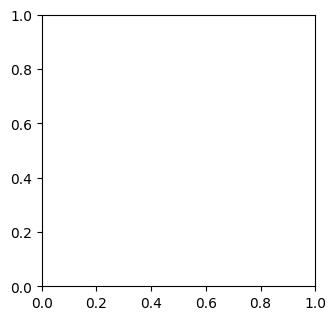

In [55]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()